In [34]:
import cobra
from cobra.io import read_sbml_model
from pprint import pprint
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from cobra.medium import minimal_medium

from process_bigraph import Composite
from process_bigraph import ProcessTypes
from process_bigraph.emitter import gather_emitter_results

from cdFBA import register_types
from cdFBA.processes.dfba import dFBA, UpdateEnvironment, StaticConcentration, Injector, WaveFunction

from cdFBA.utils import make_cdfba_composite, get_injector_spec, get_wave_spec, get_static_spec, set_concentration, set_kinetics, get_exchanges

In [35]:
# Goal: Replicate Adrian et al. model quantitatively using cdFBA

# 3 bacteria species
# /Users/rebekahsheih/PycharmProjects/Rebekahs_Rotation_Project/Vivarium/cdFBA-main/Notebooks/sbml_mini/Bacteroides_thetaiotaomicron_VPI_5482.xml
# /Users/rebekahsheih/PycharmProjects/Rebekahs_Rotation_Project/Vivarium/cdFBA-main/Notebooks/sbml_mini/Methanobrevibacter_smithii_ATCC_35061.xml
# /Users/rebekahsheih/PycharmProjects/Rebekahs_Rotation_Project/Vivarium/cdFBA-main/Notebooks/sbml_mini/Eubacterium_rectale_ATCC_33656.xml

In [36]:
b_thetaiotaomicron = cobra.io.read_sbml_model(
    "/Vivarium/cdFBA-main/Notebooks/sbml_mini/Bacteroides_thetaiotaomicron_VPI_5482.xml")

In [37]:
# interested in following exchange reactions: acetate, butyrate, CO2, H2, CH4, and a polysaccharide

# make it so that we are in minimal media (have NO other carbon source besides cholate)

In [38]:
gut_models = {
    "B_thetaiotaomicron": "/Users/rebekahsheih/PycharmProjects/Rebekahs_Rotation_Project/Vivarium/cdFBA-main/Notebooks/sbml_mini/Bacteroides_thetaiotaomicron_VPI_5482.xml",
}
models = {k: read_sbml_model(v) for k, v in gut_models.items()}

In [39]:
exchanges = ['EX_ac(e)', 'EX_cholate(e)'] # acetate, butyrate, CO2, H2, methane, exopolysaccharide, Google how to combine 3 exchange

volume = 2

# dFBA model
spec = make_cdfba_composite(gut_models, medium_type=None, exchanges=exchanges, volume=volume, interval=0.1)

pprint(spec)

{'Shared Environment': {'concentrations': {'B_thetaiotaomicron': 0.25,
                                           'Cholate': 10.0,
                                           'acetate': 10.0},
                        'counts': {'B_thetaiotaomicron': 0.5,
                                   'Cholate': 20,
                                   'acetate': 20},
                        'volume': 2},
 'Species': {'B_thetaiotaomicron': {'_type': 'process',
                                    'address': 'local:dFBA',
                                    'config': {'bounds': {},
                                               'changes': {'bounds': {},
                                                           'gene_knockout': [],
                                                           'kinetics': {},
                                                           'reaction_knockout': []},
                                               'kinetics': {'Cholate': (0.5,
                                       

In [40]:
#Set reaction bounds
spec['Species']['B_thetaiotaomicron']['config']['bounds'] = {
            "EX_o2(e)": {"lower": -2, "upper": None},
            "DM_atp_c_": {"lower": 1, "upper": 1}
        }

In [41]:
#set external substrate concentrations
concentrations = {      # abundance of exopolysaccharide, limit acetate so that it has to come from keystone species
    'acetate': 0,
    'Cholate': 5
}
set_concentration(spec, concentrations)

In [42]:
#set kinetics
kinetics = {
    'acetate': (0.5, 5),
    'Cholate': (0.001, 8) # reduce km, increase Vmax
}
for species in gut_models.keys():
    set_kinetics(species, spec, kinetics)
pprint(spec)

{'Shared Environment': {'concentrations': {'B_thetaiotaomicron': 0.25,
                                           'Cholate': 5,
                                           'acetate': 0},
                        'counts': {'B_thetaiotaomicron': 0.5,
                                   'Cholate': 10,
                                   'acetate': 0},
                        'volume': 2},
 'Species': {'B_thetaiotaomicron': {'_type': 'process',
                                    'address': 'local:dFBA',
                                    'config': {'bounds': {'DM_atp_c_': {'lower': 1,
                                                                        'upper': 1},
                                                          'EX_o2(e)': {'lower': -2,
                                                                       'upper': None}},
                                               'changes': {'bounds': {},
                                                           'gene_knockout': [],
   

In [43]:
#set emitter specs
spec['emitter'] = {
        "_type": "step",
        "address": "local:ram-emitter",
        "config": {
            "emit": {
                "shared_environment": "any",
                "global_time": "any",
            }
        },
        "inputs": {
            "shared_environment": ["Shared Environment"],
            "global_time": ["global_time"]
        }
    }

In [44]:
#create the core object
core = ProcessTypes()
#register data types
core = register_types(core)
#register all processes and steps
core.register_process('dFBA', dFBA)
core.register_process('UpdateEnvironment', UpdateEnvironment)
core.register_process('StaticConcentration', StaticConcentration)
core.register_process('WaveFunction', WaveFunction)
core.register_process('Injector', Injector)

In [45]:
#create simulation composite
sim = Composite({
        "state": spec,
        },
        core=core
    )

In [46]:
#run simulation
sim.run(20)

In [47]:
#gather results
results = gather_emitter_results(sim)[('emitter',)]

In [48]:
#extract time-series data
timepoints = []
for timepoint in results:
    time = timepoint.pop('global_time')
    timepoints.append(time)
env = [timepoint['shared_environment']['concentrations'] for timepoint in results]
env_combined = {}
for d in env:
    for key, value in d.items():
        if key not in env_combined:
            env_combined[key] = []
        env_combined[key].append(value)

In [49]:
results # Problem: cholate not being consumed

[{'shared_environment': {'concentrations': {'acetate': 0.0,
    'Cholate': 5.0,
    'B_thetaiotaomicron': 0.25},
   'counts': {'acetate': 0.0, 'Cholate': 10.0, 'B_thetaiotaomicron': 0.5},
   'volume': 2.0}},
 {'shared_environment': {'counts': {'acetate': 0.0,
    'Cholate': 10.0,
    'B_thetaiotaomicron': 0.5},
   'concentrations': {'acetate': 0.0,
    'Cholate': 5.0,
    'B_thetaiotaomicron': 0.25},
   'volume': 2.0}},
 {'shared_environment': {'counts': {'acetate': np.float64(50.0),
    'Cholate': np.float64(9.6000799840032),
    'B_thetaiotaomicron': np.float64(5.714097818188021)},
   'concentrations': {'acetate': np.float64(25.0),
    'Cholate': np.float64(4.8000399920016),
    'B_thetaiotaomicron': np.float64(2.8570489090940105)},
   'volume': 2.0}},
 {'shared_environment': {'counts': {'acetate': np.float64(621.409781818802),
    'Cholate': np.float64(5.029753872793011),
    'B_thetaiotaomicron': np.float64(65.30182775164239)},
   'concentrations': {'acetate': np.float64(310.704890

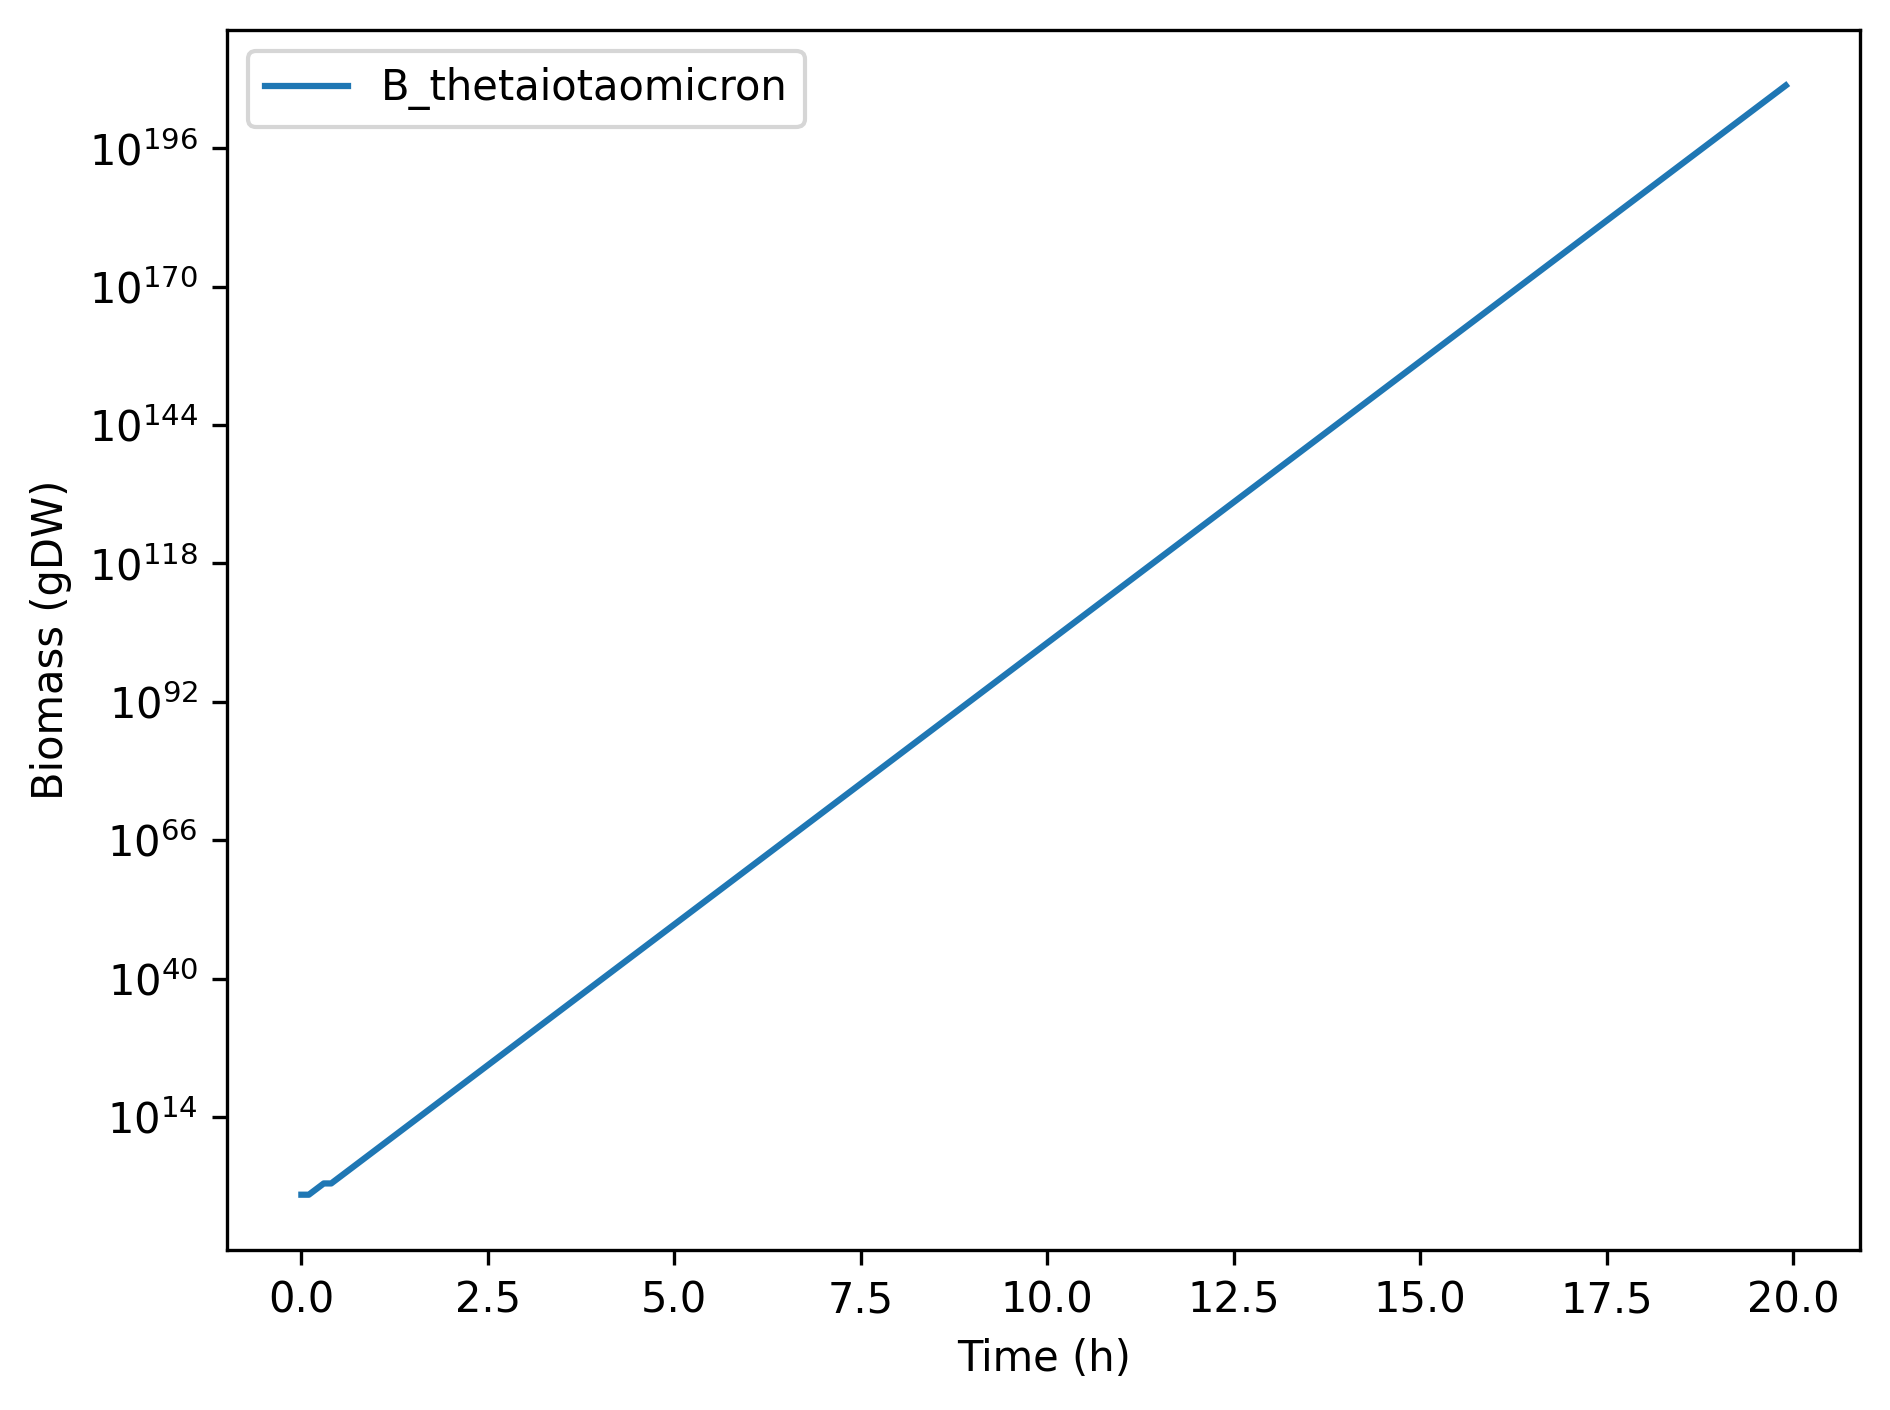

In [50]:
#plot results for biomass
fig, ax = plt.subplots(dpi=300)
for key, value in env_combined.items():
    if key not in ['acetate', 'Cholate']:
        ax.plot(timepoints, env_combined[key], label=key)
        ax.set_yscale('log')
plt.xlabel('Time (h)')
plt.ylabel('Biomass (gDW)')
plt.legend()
plt.tight_layout()
plt.show()

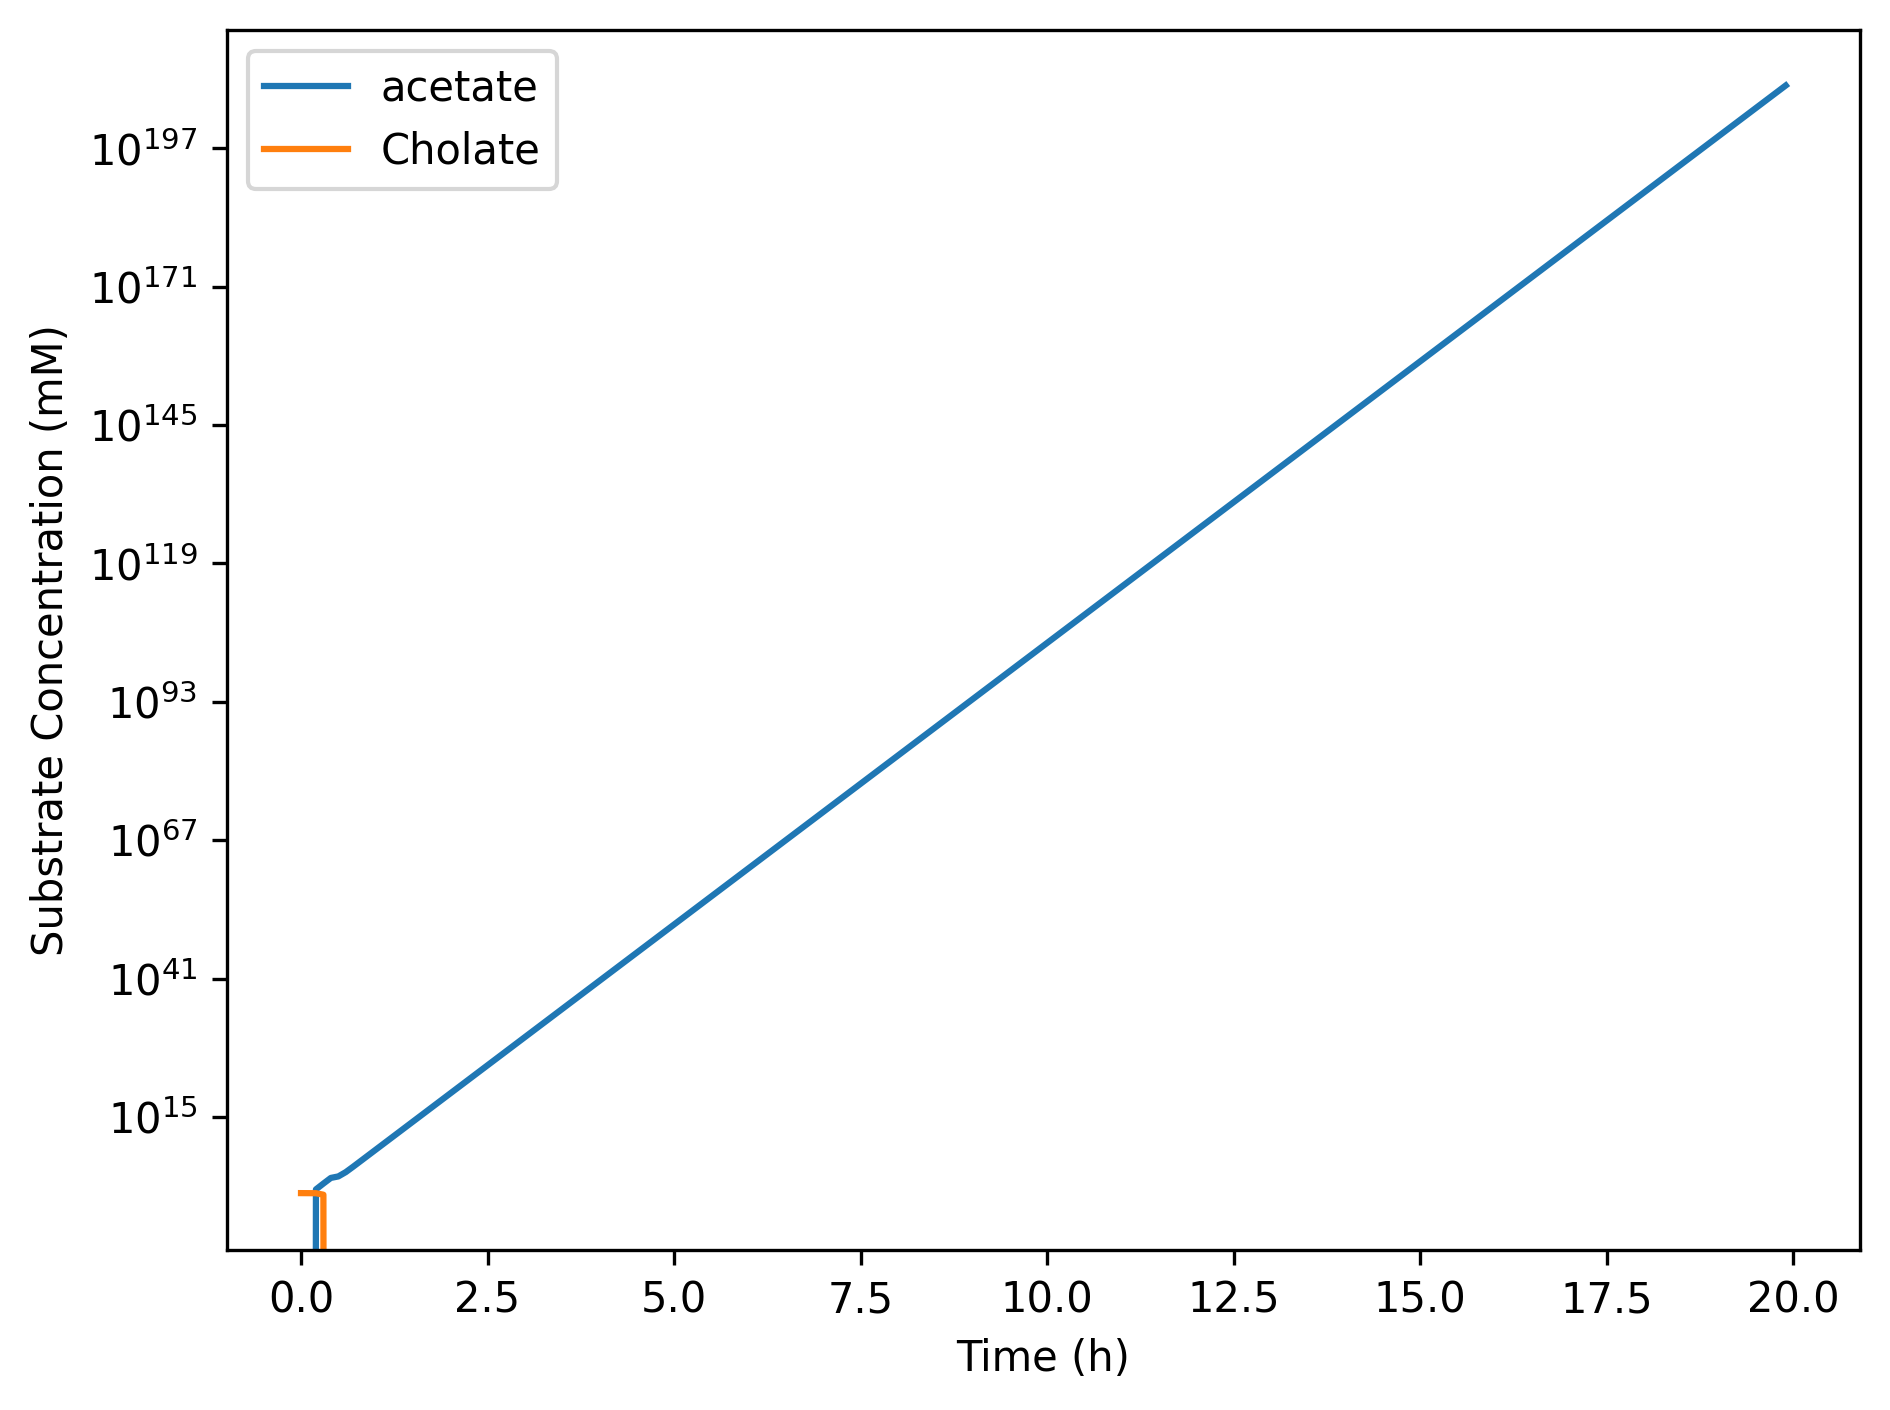

In [51]:
#plot substrates
fig, ax = plt.subplots(dpi=300)
for key, value in env_combined.items():
    if key in ['acetate', 'Cholate']:
        ax.plot(timepoints, env_combined[key], label=key)
        ax.set_yscale('log')
plt.xlabel('Time (h)')
plt.ylabel('Substrate Concentration (mM)')
plt.legend()
plt.tight_layout()
plt.show()

In [52]:
# TODO
# Look at just ONE species and see if it's consuming polysaccharide and producing acetate